In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from tqdm import tqdm
import pickle

In [2]:
!gdown --id 1HdxAq1EX_YKn7y1p2KOs_zm4uPHBBQ-Y

Downloading...
From: https://drive.google.com/uc?id=1HdxAq1EX_YKn7y1p2KOs_zm4uPHBBQ-Y
To: /content/preprocessed_data.csv
100% 115M/115M [00:00<00:00, 141MB/s]


In [18]:
df = pd.read_csv('preprocessed_data.csv')
df = df.dropna(axis=0)
df1 = df[df['Score'] > 3].sample(2000)
df0 = df[df['Score'] < 3].sample(2000)
dff = pd.concat([df1,df0],axis=0)
df = dff.sample(frac=1).reset_index(drop=True)
df.Score = df.Score.apply(lambda x: 1 if x > 3 else 0)
preprocessed_reviews = df.clean_text.values
print(df.shape)
df.head()

(4000, 3)


,Time,clean_text,Score
0,1334016000,canned vomit tastes like vomit jar goes velvee...,0
1,1340582400,terrible artificial sweetener taste juice terr...,0
2,1314489600,cinnamon altoids love product carry car times ...,1
3,1321401600,love wilton not color made basketball cake son...,0
4,1326844800,fantastic price amazing whole foods family use...,1


## Bag of Words

In [19]:
#BoW
count_vect = CountVectorizer(max_features=2000) #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("Some Feature names: ", count_vect.get_feature_names()[:10])
print('*'*50)

bow_vect = count_vect.transform(preprocessed_reviews)
print("The Type of count vectorizer: ",type(bow_vect))
print("Shape of out text BOW vectorizer: ",bow_vect.get_shape())
print("Number of unique words: ", bow_vect.get_shape()[1])

Some Feature names:  ['able', 'absolute', 'absolutely', 'acceptable', 'according', 'acid', 'across', 'actual', 'actually', 'ad']
**************************************************
The Type of count vectorizer:  <class 'scipy.sparse.csr.csr_matrix'>
Shape of out text BOW vectorizer:  (4000, 2000)
Number of unique words:  2000


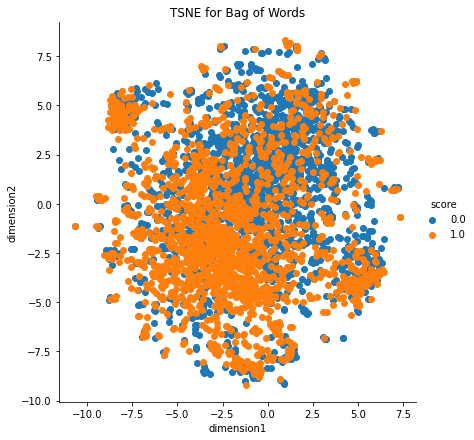

In [31]:
tsne = TSNE(n_components=2,perplexity=60,n_iter=5000, n_jobs=-1)
tsne_result = tsne.fit_transform(bow_vect)
tsne_new = np.hstack([tsne_result,df['Score'].values.reshape(-1,1)])
tsne_df = pd.DataFrame(data=tsne_new, columns=("dimension1", "dimension2", "score"))
# Ploting the result
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dimension1', 'dimension2').add_legend()
plt.title("TSNE for Bag of Words")
plt.show()

## TF-IDF

In [21]:
tf_idf_vect = TfidfVectorizer(min_df=10, max_features=2000)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('*'*50)

tfidf_vect = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(tfidf_vect))
print("the shape of out text TFIDF vectorizer ",tfidf_vect.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidf_vect.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'absolute', 'absolutely', 'acceptable', 'according', 'acid', 'acidic', 'across', 'active', 'actual']
**************************************************
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4000, 2000)
the number of unique words including both unigrams and bigrams  2000


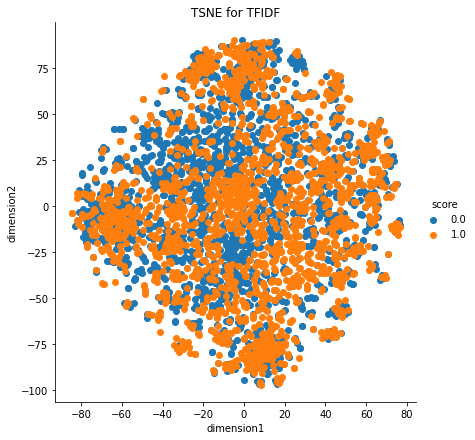

In [22]:
tsne = TSNE(n_components=2,perplexity=30,n_iter=5000)
tsne_result = tsne.fit_transform(tfidf_vect)
tsne_new = np.hstack([tsne_result,df['Score'].values.reshape(-1,1)])
tsne_df = pd.DataFrame(data=tsne_new, columns=("dimension1", "dimension2", "score"))
# Ploting the result
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dimension1', 'dimension2').add_legend()
plt.title("TSNE for TFIDF")
plt.show()

## Word2Vec

In [23]:
sentences = [review.split() for review in preprocessed_reviews]
# min_count = 5 considers only words that occured atleast 5 times
# size = length of vector
w2v_model = Word2Vec(sentences,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

## Average Word2Vec

In [24]:
sentence_vectors = []; # the avg-w2v for each sentence/review is stored in this list

for sentence in tqdm(sentences): # for each review/sentence
    sentence_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence: # for each word in a review/sentence
        if word in w2v_words: 
            vec = w2v_model.wv[word]
            sentence_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sentence_vec /= cnt_words
    sentence_vectors.append(sentence_vec)
print('Final vocab size:',len(sentence_vectors))
print('Dimensionality of the word vectors:',len(sentence_vectors[0]))

100%|██████████| 4000/4000 [00:05<00:00, 708.51it/s]

Final vocab size: 4000
Dimensionality of the word vectors: 50


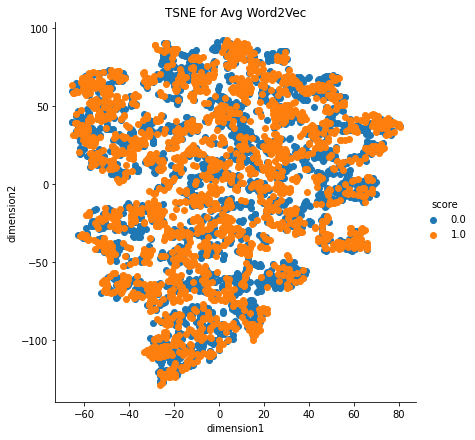

In [25]:
tsne = TSNE(n_components=2,perplexity=30,n_iter=5000)
tsne_result = tsne.fit_transform(np.array(sentence_vectors))
tsne_new = np.hstack([tsne_result,df['Score'].values.reshape(-1,1)])
tsne_df = pd.DataFrame(data=tsne_new, columns=("dimension1", "dimension2", "score"))
# Ploting the result
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dimension1', 'dimension2').add_legend()
plt.title("TSNE for Avg Word2Vec")
plt.show()

## TF-IDF Word2Vec

In [26]:
model = TfidfVectorizer()
model.fit(preprocessed_reviews)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
# TF-IDF weighted Word2Vec
tfidf_feats = model.get_feature_names() # tfidf words/col-names

sentences = [review.split() for review in preprocessed_reviews]
sentence_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sentence in tqdm(sentences): # for each review/sentence 
    sentence_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sentence: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feats:
            vec = w2v_model.wv[word]
             #tf_idf = tf_idf_matrix[row, tfidf_feats.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence))
            sentence_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sentence_vec /= weight_sum
    sentence_vectors.append(sentence_vec)
    row += 1
print('Final vocab size:',len(sentence_vectors))
print('Dimensionality of the word vectors:',len(sentence_vectors[0]))

100%|██████████| 4000/4000 [00:42<00:00, 93.90it/s]

Final vocab size: 4000
Dimensionality of the word vectors: 50


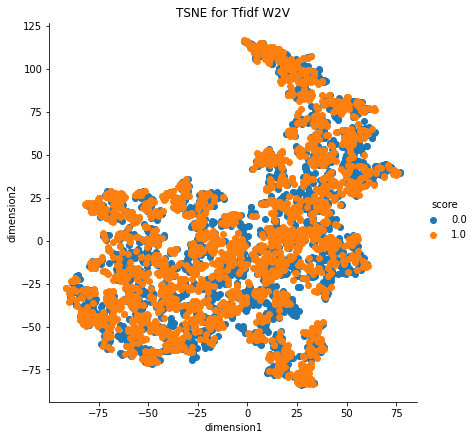

In [27]:
tsne = TSNE(n_components=2,perplexity=30,n_iter=5000)
tsne_result = tsne.fit_transform(np.array(sentence_vectors))
tsne_new = np.hstack([tsne_result,df['Score'].values.reshape(-1,1)])
tsne_df = pd.DataFrame(data=tsne_new, columns=("dimension1", "dimension2", "score"))
# Ploting the result
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dimension1', 'dimension2').add_legend()
plt.title("TSNE for Tfidf W2V")
plt.show()

Steps followed for TSNE:
* Keeping perplexity constant ran TSNE at different iterations and found most stable iteration.
* Now keeping that iteration ran TSNE at diifferent perplexity to get a better result.
* Once I got stable result, ran TSNE again with same parameters

### Observation:

* None of the figures could clearly seperate positive reviews from the negative reviews